### Standard code taken from Tirgul with some minor changes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import *

In [2]:
def plot_image(image, title=""):
    image = np.clip(image,0,255)
    image = image.astype(np.uint8)
    
    # added conditional for title
    if title:
        plt.title(title)

    plt.imshow(image,cmap='gray')
    plt.show()

In [3]:
# changed plot_image a bit to plot circles as well
from matplotlib.patches import Circle

def plot_with_circles(image, circles):
    figure, axes = plt.subplots()
    image = np.clip(image,0,255)
    image = image.astype(np.uint8)

    plt.imshow(image,cmap='gray')

    for x,y,r in circles:
        axes.add_patch(Circle((x,y), r, facecolor='None',  edgecolor='w'))

In [4]:
# using requests instead because urllib returned an HTTP 403 code 
import requests

# image we have to submit with
# https://u.cs.biu.ac.il/~kapaho/IP/Images/binary/binary1.tiff

# more images with actual balls in them
# https://u.cs.biu.ac.il/~kapaho/IP/Images/balls4.tiff
# https://u.cs.biu.ac.il/~kapaho/IP/Images/balls1.tiff
image_url = 'https://u.cs.biu.ac.il/~kapaho/IP/Images/balls1.tiff'
image_path = 'image.tiff'
with open(image_path, 'wb') as f:
    f.write(requests.get(image_url).content)

In [5]:
# load image and convert to grayscale
image = plt.imread(image_path).astype(float)
#gray_image = rgb2gray_naive(image).astype(float)

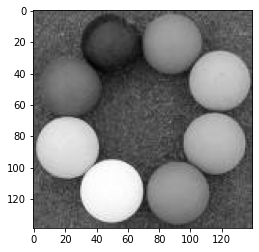

In [6]:
plot_image(image)

### Filtering functionality

In [7]:
# naive sum-convolution on an image with a given kernel
def conv(image, kernel):
    z = np.zeros(image.shape)
    h, w = image.shape
    
    # normal iterative solution
    for i in range(1, h-1):
        for j in range(1, w-1):
            window = image[i-1:i+2, j-1:j+2]
            z[i,j] = (window * kernel).sum()
    return z

In [8]:
# applies the sobel filter on an image, and returns the gradiant and the gradiant-angle matrices
def sobel(image):
    k_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    k_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    i_x = conv(image, k_x)
    i_y = conv(image, k_y)
    
    # normalize gradiant matrix, and create angle matrix
    g = np.hypot(i_x, i_y)
    g = g / g.max() * 255 
    theta = np.arctan2(i_y, i_x)
    
    return (g, theta)

### Edge Refinement functionality

In [9]:
# given a sobel filtered image and its gradiant angle matrix
# suppress all non-max-points in their edge direction
def non_max_suppression(sobel_g, sobel_t):

    # map angles to positive degrees
    angles = np.degrees(sobel_t)
    angles[angles < 0] += 180
    h, w = angles.shape
    z = np.zeros((h,w))

    # sort all angles based on direction
    bins = [0, 22.5, 67.5, 112.5, 157.5, 181]
    angle_bins = np.digitize(angles, bins)
    angle_bins = np.where(angle_bins == 5, 1, angle_bins)
    
    # indices of neighbors to check for each direction in a 3x3 neighborhood
    bin_indices = { 1: [(0, 1), (0, -1)],
                    2: [(1, -1), (-1, 1)],
                    3: [(1, 0), (-1, 0)],
                    4: [(-1, -1), (1, 1)] }

    # iterate over the angles and keep only the strongest pixels
    for i in range(1, h-1):
        for j in range(1, w-1):
            indices = bin_indices[angle_bins[i,j]]
            
            # compare to strongest neighbor-to-check
            if sobel_g[i,j] >= max([sobel_g[(i + k[0], j + k[1])] for k in indices]):
                z[i,j] = sobel_g[i,j]
    return z

In [10]:
''' 
    create a strength matrix. 
        1 - strong pixel, worth keeping in edge
        0 - to be ignored
        (-1) - weak pixel, should be looked at in the next stage
    
    given two threshold values of percents
'''
def double_threshold(image, low_t_ratio=0.05, high_t_ratio=0.09):
    
    # thresholds
    high_t = image.max() * high_t_ratio;
    low_t = high_t * low_t_ratio;
    
    # transform strong pixels to 1, weak to (-1) and the rest to 0
    return np.vectorize(lambda x: 0 if x < low_t else 1 if x >= high_t else -1)(image)

In [11]:
# weak pixels in the neighborhood of strong ones become strong too.
# return a matrix of all strong pixels.
# naive implementation
def hysteresis(strength, strong_color=255):

    # keep track of strong pixels as 1, the rest as 0
    h, w = strength.shape
    z = strength > 0

    #tmp = strength > 0
    weak = np.argwhere(strength == -1)
    
    # for each weak pixel, look for a strong pixel in its 3 neighborhood
    for i,j in weak:
        #z[i,j] = np.any(tmp[i-1:i+2, j-1:j+2])
        
        window = strength[i-1:i+2, j-1:j+2]
        if np.any(window == 1):
            z[i,j] = 1
        
    return np.clip(z * strong_color, 0, 255)

## Canny Edge Detection

**Step 1 -** filter the image using a gaussian convolution

In [12]:
# this filtering makes the image.. weird
k_size = 3
kernel = np.ones((k_size, k_size)) / k_size**2

filtered_gaus = conv(image, kernel)

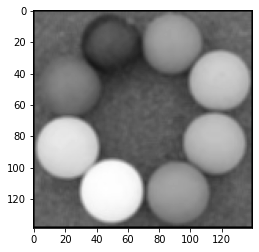

In [13]:
plot_image(filtered_gaus)

**Step 2 -** apply a sobel filter on the result to approximate the gradiants

In [14]:
# create the gradiant size and gradiant direction approximation matrices
sob_g, sob_theta = sobel(filtered_gaus)

**Step 3 -** use non-max-suppression to leave only the edge pixels that are the 'strongest' in their edge direction

In [15]:
non_m = non_max_suppression(sob_g, sob_theta)

**Step 4 -** refine further by marking pixels by strength, based on 2 thresholds

In [16]:
# a pixel strength matrix. contains {-1, 0, 1}
# (-1) - weak pixel, 1 - strong pixel, and 0 - to be ignored
strength_matrix = double_threshold(non_m)

**Step 5 -** and refine even further by letting only 'weak' pixels that have 'strong' neighbors remain, alongside previously 'strong' pixels

In [17]:
canny_final = hysteresis(strength_matrix)

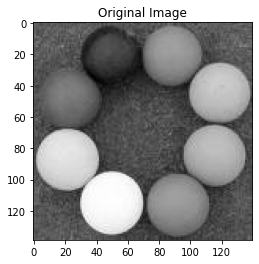

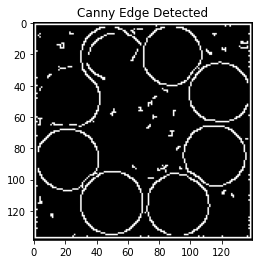

In [18]:
plot_image(image, "Original Image")
plot_image(canny_final, "Canny Edge Detected")

## Hough Circles

In [19]:
# it is only semi-working.
from collections import defaultdict
''' 
    locates circles in a given image that have radii between [rmin, rmax].
  
        steps - each edgepoint votes 'steps' times for each radius.
        threshold - minimum portion of the circle to be discovered.           
'''

def hough_circles(image, rmin, rmax, steps, threshold, mind=0):

    # we will be using the a-b-r hough space as our accumulator
    votes = defaultdict(int)
    edge_indices = np.argwhere(canny_final > 0)
    
    # caching points`
    radii = np.arange(rmin, rmax + 1)
    thetas = 2*np.pi* np.arange(steps) / steps
    points = [(r, int(r*np.cos(t)), int(r*np.sin(t))) for t in thetas for r in radii]
 
 
    # each edge_pixel votes for centers and radii
    for x_0, y_0 in edge_indices:

        # for each radius, go over all possible angles
        for r, cos, sin in points:

            # a = x_0 - r*cos(theta)
            # b = y_0 - r*sin(theta)
            a = x_0 - cos
            b = y_0 - sin
            votes[(a, b, r)] += 1



    # keep only circles that are mostly discovered, and ones that are not 
    # too close to each other
    # this is not a good local-maxima detector, but I couldn't find any better
    circles = []
    votes_sorted = sorted(votes.items(), key=lambda i: -i[1])
    for candidate, votes in votes_sorted:
        a, b, r = candidate

        # if the circle has enough points discovered
        if (votes / steps) >= threshold:

            # if not in any circle, add it
            out_circle = lambda x,y,r: (a-x)**2 +(b-y)**2 > max(r, mind)**2 
            if all(out_circle(xc,yc,rc) for xc,yc,rc in circles):
                circles.append((a, b, r))
    
    return circles

In [20]:
# you really have to play with parameters.. 
rmax = 20
rmin = 10
thresh = 0.4
steps = 360

circles = hough_circles(canny_final, rmin, rmax, steps, thresh)

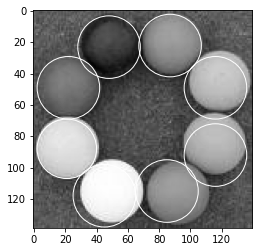

In [21]:
plot_with_circles(image, circles)